## Wind Farm A Layout Based on Wake Effect

In [3]:
import pandas as pd
import numpy as np
import os

dataset_ids = [0,3,10,13,14,17,22,24,25,26,38,40,42,45,51,68,69,71,72,73,84,92]
input_dir = r"D:\Master Thesis New Data Set\CARE DATA SET\CARE_To_Compare\Wind Farm A\Wind Farm A\datasets"

scores = []

for dataset_id in dataset_ids:
    file_path = os.path.join(input_dir, f"{dataset_id}.csv")
    df = pd.read_csv(file_path, delimiter=';')

    df['sensor_50'] = df['sensor_50'].clip(lower=0)
    normal = df[(df['status_type_id'] == 0) & (df['train_test'] == 'train')]
    rated_power = normal['sensor_50'].max()

    if rated_power == 0 or np.isnan(rated_power):
        continue

    subset = normal[(normal['wind_speed_3_avg'] >= 6) & (normal['wind_speed_3_avg'] <= 10)]
    avg_ratio = subset['sensor_50'].mean() / rated_power
    scores.append((dataset_id, avg_ratio))

# Rank by avg_ratio
scores.sort(key=lambda x: x[1], reverse=True)

# Split 25% top as Strict, 25% bottom as Lenient
n = len(scores)
strict_cut = int(n * 0.25)
lenient_cut = int(n * 0.75)

for i, (dataset_id, avg_ratio) in enumerate(scores):
    if i < strict_cut:
        pipeline = "Strict"
    elif i >= lenient_cut:
        pipeline = "Lenient"
    else:
        pipeline = "Neutral"
    print(f"Dataset {dataset_id}: avg_ratio={avg_ratio:.3f} → {pipeline}")


Dataset 38: avg_ratio=0.444 → Strict
Dataset 45: avg_ratio=0.439 → Strict
Dataset 22: avg_ratio=0.438 → Strict
Dataset 84: avg_ratio=0.438 → Strict
Dataset 72: avg_ratio=0.436 → Strict
Dataset 51: avg_ratio=0.435 → Neutral
Dataset 14: avg_ratio=0.432 → Neutral
Dataset 13: avg_ratio=0.430 → Neutral
Dataset 73: avg_ratio=0.423 → Neutral
Dataset 0: avg_ratio=0.421 → Neutral
Dataset 26: avg_ratio=0.420 → Neutral
Dataset 24: avg_ratio=0.419 → Neutral
Dataset 71: avg_ratio=0.417 → Neutral
Dataset 17: avg_ratio=0.407 → Neutral
Dataset 68: avg_ratio=0.406 → Neutral
Dataset 10: avg_ratio=0.405 → Neutral
Dataset 69: avg_ratio=0.405 → Lenient
Dataset 25: avg_ratio=0.401 → Lenient
Dataset 42: avg_ratio=0.401 → Lenient
Dataset 92: avg_ratio=0.400 → Lenient
Dataset 3: avg_ratio=0.391 → Lenient
Dataset 40: avg_ratio=0.380 → Lenient



Turbine Layout Table:
--------------------------------------------------
WT 13  | Score: 0.438 | Row: Front | Datasets: [14, 38, 45, 84]
WT 21  | Score: 0.435 | Row: Front | Datasets: [13, 22, 51, 72]
WT 0   | Score: 0.420 | Row: Front | Datasets: [0, 24, 26, 71, 73]
WT 11  | Score: 0.403 | Row: Back  | Datasets: [25, 68, 69, 92]
WT 10  | Score: 0.397 | Row: Back  | Datasets: [3, 10, 17, 40, 42]
--------------------------------------------------


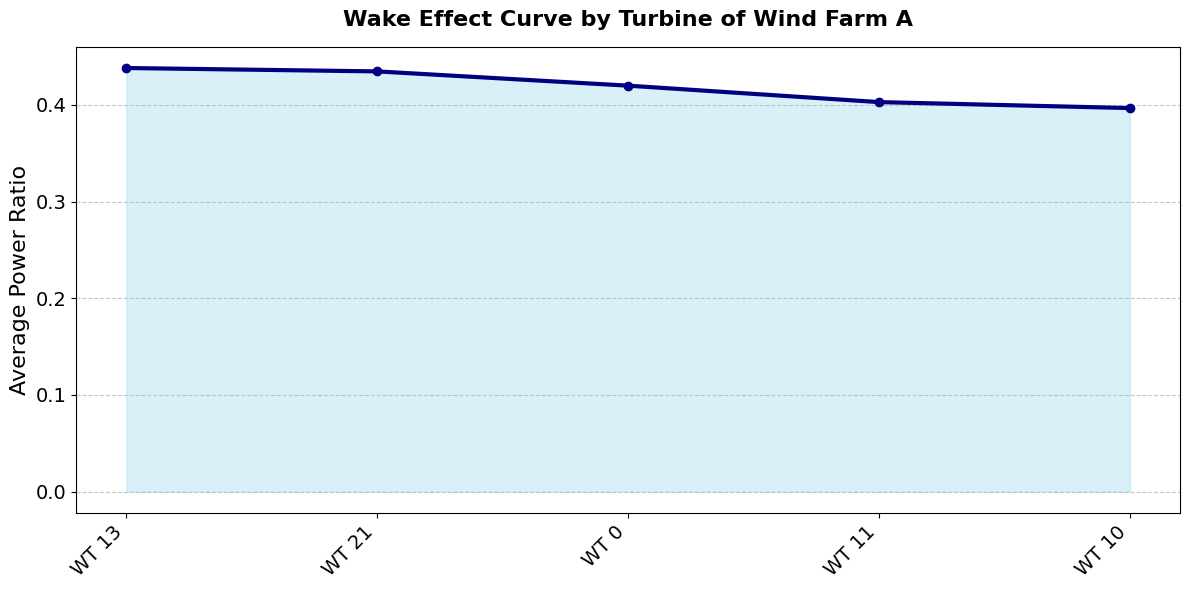

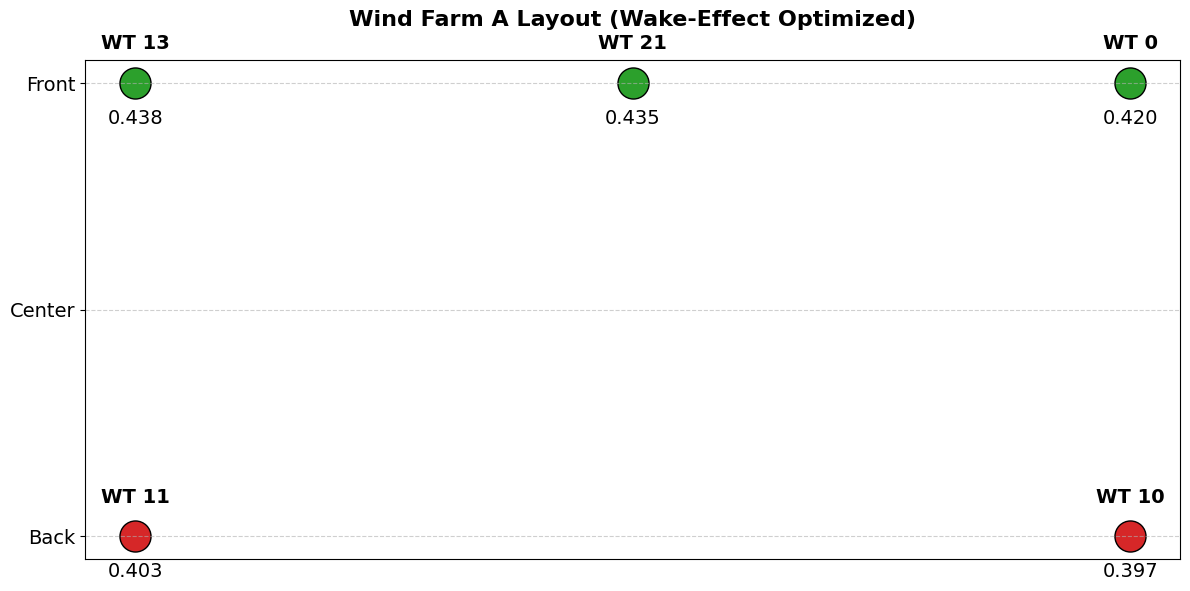

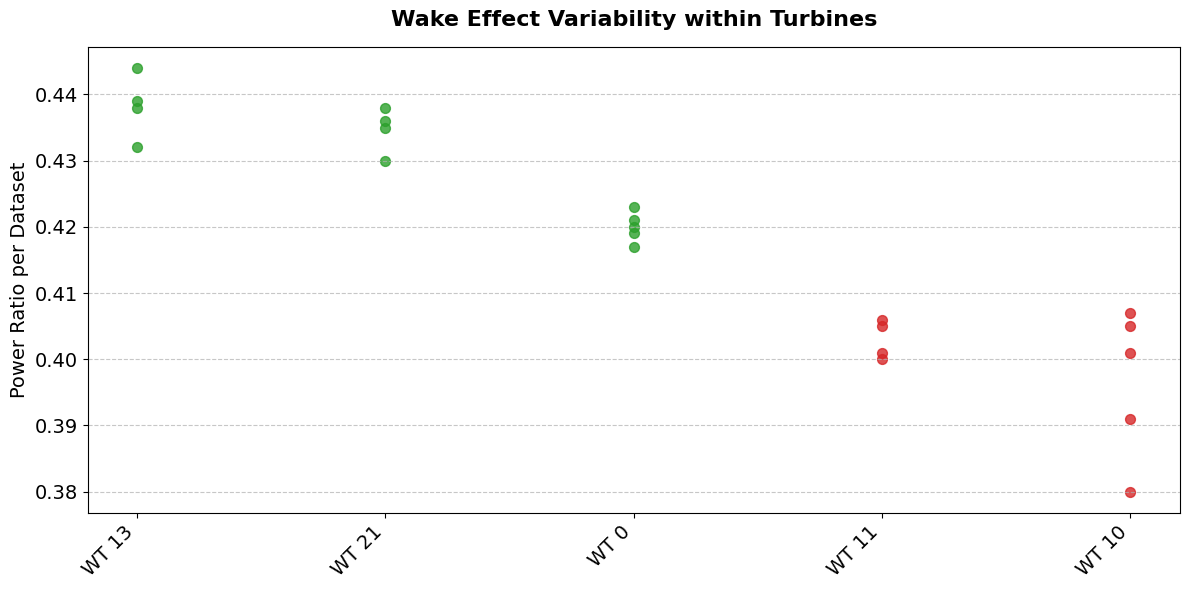

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =========================
# 1️⃣ Data & Turbine Mapping
# =========================
data_scores = {
    38: 0.444, 45: 0.439, 22: 0.438, 84: 0.438, 72: 0.436,
    51: 0.435, 14: 0.432, 13: 0.430, 73: 0.423, 0: 0.421,
    26: 0.420, 24: 0.419, 71: 0.417, 17: 0.407, 68: 0.406,
    10: 0.405, 69: 0.405, 25: 0.401, 42: 0.401, 92: 0.400,
    3: 0.391, 40: 0.380
}

wt_map = {
    "WT 13": [14, 38, 45, 84],
    "WT 21": [13, 22, 51, 72],
    "WT 0":  [0, 24, 26, 71, 73],
    "WT 11": [25, 68, 69, 92],
    "WT 10": [3, 10, 17, 40, 42]
}

# =========================
# 2️⃣ Calculate Turbine Scores
# =========================
turbine_scores = {}
turbine_datasets = {}
for wt, datasets in wt_map.items():
    vals = [data_scores[d] for d in datasets if d in data_scores]
    if vals:
        turbine_scores[wt] = np.mean(vals)
        turbine_datasets[wt] = vals

# =========================
# 3️⃣ Assign Rows by Median (Higher score = Front)
# =========================
layout_df = pd.DataFrame(list(turbine_scores.items()), columns=["Turbine", "Score"])
median_score = layout_df["Score"].median()

def assign_row(score):
    return "Front" if score >= median_score else "Back"

layout_df["Row"] = layout_df["Score"].apply(assign_row)

colors = {"Front": "#2ca02c", "Back": "#d62728"}

# =========================
# 4️⃣ Print Table: Turbine, Dataset, Row
# =========================
print("\nTurbine Layout Table:")
print("-" * 50)
for _, row in layout_df.iterrows():
    wt = row["Turbine"]
    score = row["Score"]
    assigned_row = row["Row"]
    datasets = wt_map[wt]
    print(f"{wt:<6} | Score: {score:.3f} | Row: {assigned_row:<5} | Datasets: {datasets}")
print("-" * 50)

# =========================
plt.figure(figsize=(12, 6))
plt.plot(layout_df["Turbine"], layout_df["Score"], marker='o', linewidth=3, color="navy")
plt.fill_between(layout_df["Turbine"], layout_df["Score"], color="skyblue", alpha=0.3)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Average Power Ratio", fontsize=16)

plt.title("Wake Effect Curve by Turbine of Wind Farm A", fontsize=16, weight="bold", pad=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("wind_farm_A_layout.png", dpi=300, bbox_inches="tight")
plt.show()


# =========================
# 3️⃣ Wind Farm Layout Diagram
# =========================
plt.figure(figsize=(12, 6))
row_y = {"Front": 3, "Center": 2, "Back": 1}
for row_name in ["Front", "Center", "Back"]:
    row_turbines = layout_df[layout_df["Row"] == row_name]
    x_positions = np.linspace(0, 10, len(row_turbines))
    for x, (wt, score, row) in zip(x_positions, row_turbines[["Turbine", "Score", "Row"]].values):
        plt.scatter(x, row_y[row], s=500, color=colors[row], edgecolor="black")
        plt.text(x, row_y[row]+0.15, wt, ha="center", fontsize=14, weight="bold")
        plt.text(x, row_y[row]-0.18, f"{score:.3f}", ha="center", fontsize=14)

plt.yticks([1, 2, 3], ["Back", "Center", "Front"], fontsize=14)
plt.xticks([])
plt.title("Wind Farm A Layout (Wake-Effect Optimized)", fontsize=16, weight="bold", pad=25)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("wind_farm_layout_A.png", dpi=300, bbox_inches="tight")  # High-res PN
plt.show()

# =========================
# 4️⃣ Wake Variability Scatter
# =========================
layout_df_sorted = layout_df.sort_values("Score", ascending=False)
plt.figure(figsize=(12, 6))
for i, wt in enumerate(layout_df_sorted["Turbine"]):
    vals = turbine_datasets[wt]
    plt.scatter([i]*len(vals), vals, color=colors[layout_df_sorted.iloc[i]["Row"]], s=50, alpha=0.8)
plt.xticks(range(len(layout_df_sorted)), layout_df_sorted["Turbine"], rotation=45, ha="right",fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Power Ratio per Dataset", fontsize=14)
plt.title("Wake Effect Variability within Turbines", fontsize=16, weight="bold", pad=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("wind_farm_layout_wakeeee_A.png", dpi=300, bbox_inches="tight")  # High-res PN
plt.show()

